In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch

In [2]:
from gluonts.dataset.multivariate_grouper import MultivariateGrouper
from gluonts.dataset.repository.datasets import dataset_recipes, get_dataset
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import MultivariateEvaluator

from pts.model.deepar import DeepAREstimator
from pts.dataset.repository.datasets import dataset_recipes
from pts.modules import StudentTOutput

## Prepeare data set

In [3]:
dataset = get_dataset("solar_nips", regenerate=False)

In [4]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='137')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

In [5]:
train_grouper = MultivariateGrouper(max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

test_grouper = MultivariateGrouper(num_test_dates=int(len(dataset.test)/len(dataset.train)), 
                                   max_target_dim=int(dataset.metadata.feat_static_cat[0].cardinality))

In [6]:
dataset_train = train_grouper(dataset.train)
dataset_test = test_grouper(dataset.test)

## Evaluator

In [7]:
evaluator = MultivariateEvaluator(quantiles=(np.arange(20)/20.0)[1:],
                                  target_agg_funcs={'sum': np.sum})

## `DeepVAR`

In [10]:
estimator = DeepAREstimator(
    distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    hidden_size=64,
    num_layers=3,
    dropout_rate=0.1,
    lags_seq=[1, 24*7],
  
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="std",
    trainer_kwargs=dict(max_epochs=100, accelerator='gpu', devices='1'),
)

In [11]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
Authorization required, but no authorization protocol specified
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: /mnt/scratch/kashif/time_match/lig

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 689.38647 (best 689.38647), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 588.01050 (best 588.01050), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 540.90814 (best 540.90814), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 523.76929 (best 523.76929), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 513.49323 (best 513.49323), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' rea

Epoch 50, global step 2550: 'train_loss' was not in top 1
Epoch 51, global step 2600: 'train_loss' was not in top 1
Epoch 52, global step 2650: 'train_loss' reached 417.49243 (best 417.49243), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=52-step=2650.ckpt' as top 1
Epoch 53, global step 2700: 'train_loss' was not in top 1
Epoch 54, global step 2750: 'train_loss' was not in top 1
Epoch 55, global step 2800: 'train_loss' reached 416.99649 (best 416.99649), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=55-step=2800.ckpt' as top 1
Epoch 56, global step 2850: 'train_loss' reached 416.18878 (best 416.18878), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=56-step=2850.ckpt' as top 1
Epoch 57, global step 2900: 'train_loss' reached 415.00388 (best 415.00388), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_0/checkpoints/epoch=57-step=2900

In [12]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 93.53it/s]
Running evaluation: 7it [00:00, 102.87it/s]
Running evaluation: 7it [00:00, 102.61it/s]
Running evaluation: 7it [00:00, 103.33it/s]
Running evaluation: 7it [00:00, 103.50it/s]
Running evaluation: 7it [00:00, 103.34it/s]
Running evaluation: 7it [00:00, 103.18it/s]
Running evaluation: 7it [00:00, 103.15it/s]
Running evaluation: 7it [00:00, 103.45it/s]
Running evaluation: 7it [00:00, 104.17it/s]
Running evaluation: 7it [00:00, 103.45it/s]
Running evaluation: 7it [00:00, 103.57it/s]
Running evaluation: 7it [00:00, 103.38it/s]
Running evaluation: 7it [00:00, 103.23it/s]
Running evaluation: 7it [00:00, 103.28it/s]
Running evaluation: 7it [00:00, 103.51it/s]
Running evaluation: 7it [00:00, 103.97it/s]
Running evaluation: 7it [00:00, 103.73it/s]
Running evaluation: 7it [00:00, 103.76it/s]
Running evaluation: 7it [00:00, 103.71it/s]
Running evaluation: 7it [00:00, 103.40it/s]
Running evaluation: 7it [00:00, 103.26it/s]
Running evaluation: 7it [00:00, 1

### Metrics

In [13]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.4755349555573438
ND: 0.6089294763422505
NRMSE: 1.1200670568951383
MSE: 1190.0517177919899


In [14]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.429674388780364
ND-Sum: 0.5359377486356393
NRMSE-Sum: 0.9027997779803048
MSE-Sum: 14511149.964285715


In [8]:
def plot(target, forecast, prediction_length, prediction_intervals=(50.0, 90.0), color='g', fname=None):
    label_prefix = ""
    rows = 4
    cols = 4
    fig, axs = plt.subplots(rows, cols, figsize=(24, 24))
    axx = axs.ravel()
    seq_len, target_dim = target.shape
    
    ps = [50.0] + [
            50.0 + f * c / 2.0 for c in prediction_intervals for f in [-1.0, +1.0]
        ]
        
    percentiles_sorted = sorted(set(ps))
    
    def alpha_for_percentile(p):
        return (p / 100.0) ** 0.3
        
    for dim in range(0, min(rows * cols, target_dim)):
        ax = axx[dim]

        target[-2 * prediction_length :][dim].plot(ax=ax)
        
        ps_data = [forecast.quantile(p / 100.0)[:,dim] for p in percentiles_sorted]
        i_p50 = len(percentiles_sorted) // 2
        
        p50_data = ps_data[i_p50]
        p50_series = pd.Series(data=p50_data, index=forecast.index)
        p50_series.plot(color=color, ls="-", label=f"{label_prefix}median", ax=ax)
        
        for i in range(len(percentiles_sorted) // 2):
            ptile = percentiles_sorted[i]
            alpha = alpha_for_percentile(ptile)
            ax.fill_between(
                forecast.index,
                ps_data[i],
                ps_data[-i - 1],
                facecolor=color,
                alpha=alpha,
                interpolate=True,
            )
            # Hack to create labels for the error intervals.
            # Doesn't actually plot anything, because we only pass a single data point
            pd.Series(data=p50_data[:1], index=forecast.index[:1]).plot(
                color=color,
                alpha=alpha,
                linewidth=10,
                label=f"{label_prefix}{100 - ptile * 2}%",
                ax=ax,
            )

    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]    
    axx[0].legend(legend, loc="upper left")
    
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight', pad_inches=0.05)

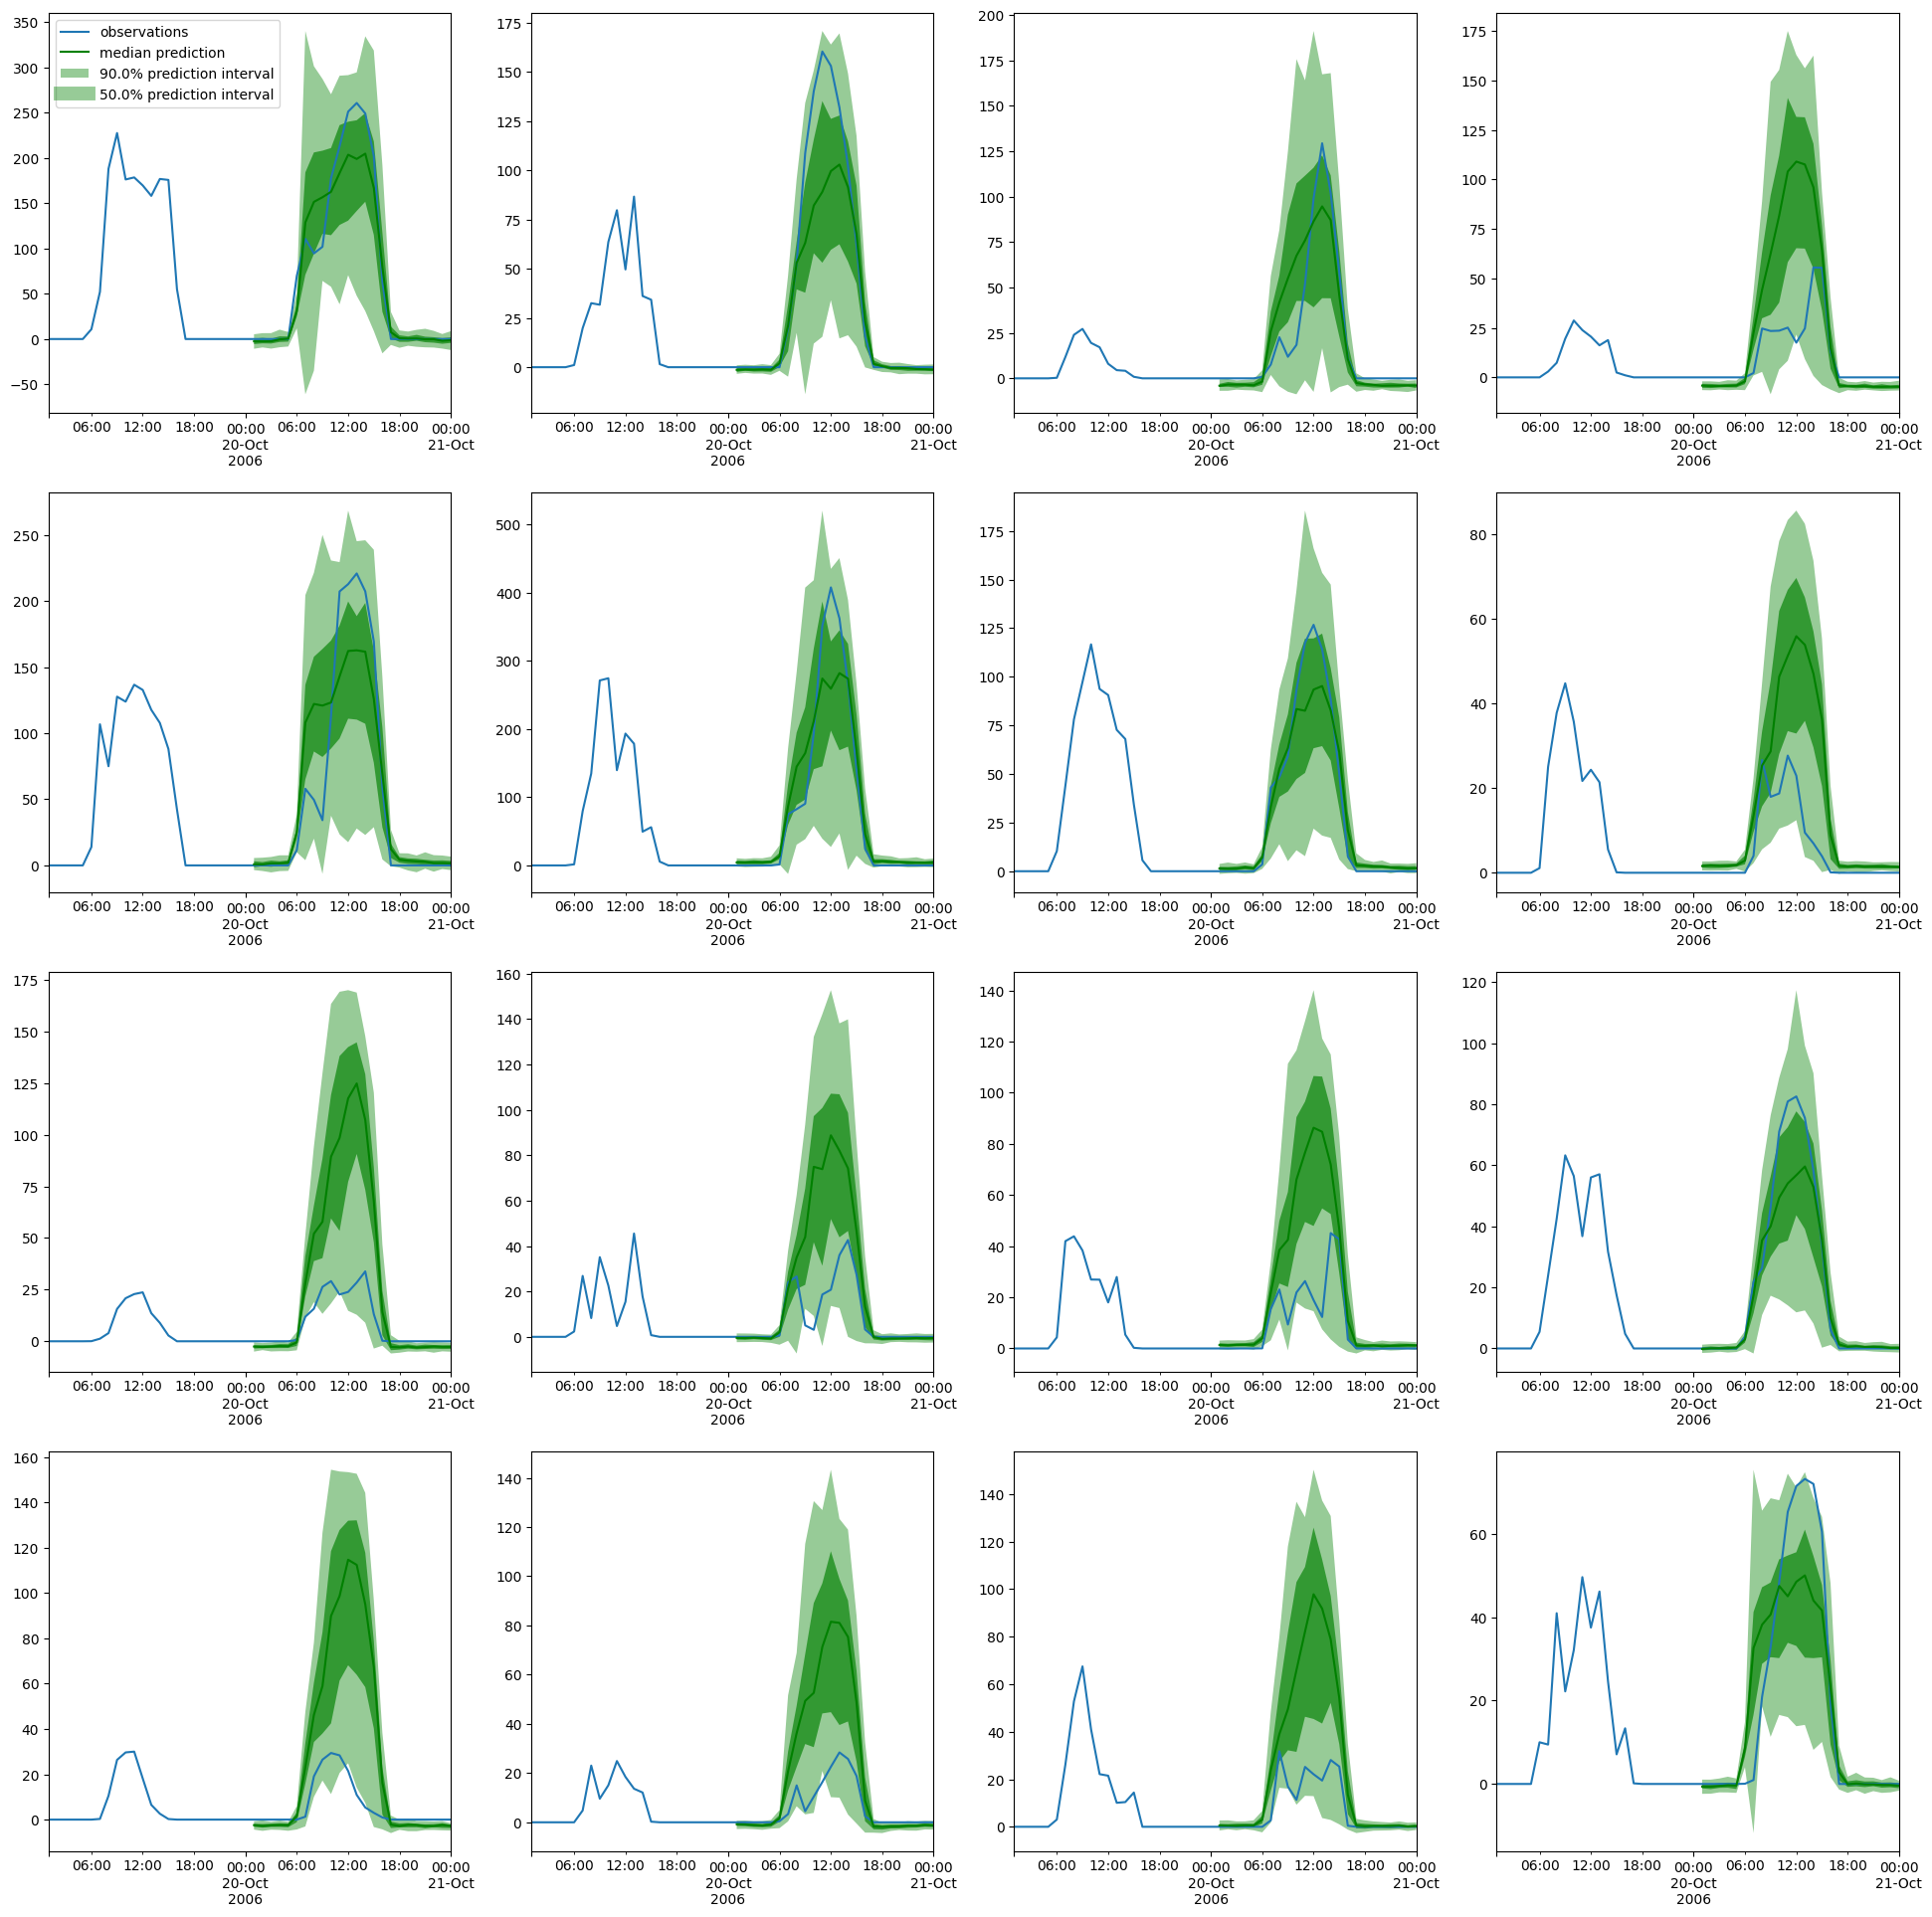

In [16]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()

## `TransformerVAR`

In [9]:
from pts.model.transformer import TransformerEstimator

In [22]:
estimator = TransformerEstimator(
    distr_output=StudentTOutput(dim=int(dataset.metadata.feat_static_cat[0].cardinality)),
    input_size=int(dataset.metadata.feat_static_cat[0].cardinality),
    d_model=256,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dropout=0.1,
    lags_seq=[1, 24*7],
    activation="gelu",
  
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*2,
    freq=dataset.metadata.freq,
    scaling="std",
    trainer_kwargs=dict(max_epochs=100, accelerator='gpu', devices='1'),
)

In [23]:
predictor = estimator.train(dataset_train, cache_data=True, shuffle_buffer_length=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:72: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params | In sizes | Out sizes        
--------------------------------------------------------------------------
0 | model | TransformerModel | 2.1 M  | ?        | [1, 100, 24

Training: 0it [00:00, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 599.13092 (best 599.13092), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 537.64111 (best 537.64111), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 519.03119 (best 519.03119), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 503.51816 (best 503.51816), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 494.87079 (best 494.87079), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=4-step=250.ckpt' as top 1
Epoch 5, global step 300: 'train_loss' rea

Epoch 59, global step 3000: 'train_loss' was not in top 1
Epoch 60, global step 3050: 'train_loss' reached 398.13812 (best 398.13812), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=60-step=3050.ckpt' as top 1
Epoch 61, global step 3100: 'train_loss' reached 394.93503 (best 394.93503), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=61-step=3100.ckpt' as top 1
Epoch 62, global step 3150: 'train_loss' was not in top 1
Epoch 63, global step 3200: 'train_loss' was not in top 1
Epoch 64, global step 3250: 'train_loss' was not in top 1
Epoch 65, global step 3300: 'train_loss' reached 388.29797 (best 388.29797), saving model to '/mnt/scratch/kashif/time_match/lightning_logs/version_5/checkpoints/epoch=65-step=3300.ckpt' as top 1
Epoch 66, global step 3350: 'train_loss' was not in top 1
Epoch 67, global step 3400: 'train_loss' was not in top 1
Epoch 68, global step 3450: 'train_loss' was not in top 1
Epoch 

In [24]:
forecast_it, ts_it = make_evaluation_predictions(dataset=dataset_test,
                                             predictor=predictor,
                                             num_samples=100)
forecasts = list(forecast_it)
targets = list(ts_it)
agg_metric, _ = evaluator(targets, forecasts, num_series=len(dataset_test))

Running evaluation: 7it [00:00, 97.68it/s]
Running evaluation: 7it [00:00, 100.40it/s]
Running evaluation: 7it [00:00, 100.86it/s]
Running evaluation: 7it [00:00, 100.31it/s]
Running evaluation: 7it [00:00, 100.80it/s]
Running evaluation: 7it [00:00, 100.36it/s]
Running evaluation: 7it [00:00, 99.39it/s]
Running evaluation: 7it [00:00, 99.35it/s]
Running evaluation: 7it [00:00, 85.32it/s]
Running evaluation: 7it [00:00, 98.92it/s]
Running evaluation: 7it [00:00, 99.22it/s]
Running evaluation: 7it [00:00, 97.31it/s]
Running evaluation: 7it [00:00, 98.60it/s]
Running evaluation: 7it [00:00, 98.98it/s]
Running evaluation: 7it [00:00, 99.36it/s]
Running evaluation: 7it [00:00, 99.05it/s]
Running evaluation: 7it [00:00, 94.03it/s]
Running evaluation: 7it [00:00, 81.53it/s]
Running evaluation: 7it [00:00, 91.33it/s]
Running evaluation: 7it [00:00, 100.11it/s]
Running evaluation: 7it [00:00, 97.57it/s]
Running evaluation: 7it [00:00, 96.64it/s]
Running evaluation: 7it [00:00, 99.54it/s]
Runni

### Metrics

In [25]:
print("CRPS: {}".format(agg_metric['mean_wQuantileLoss']))
print("ND: {}".format(agg_metric['ND']))
print("NRMSE: {}".format(agg_metric['NRMSE']))
print("MSE: {}".format(agg_metric['MSE']))

CRPS: 0.4916727518247425
ND: 0.6215976688397168
NRMSE: 1.1675458699737844
MSE: 1293.0808834623535


In [26]:
print("CRPS-Sum: {}".format(agg_metric['m_sum_mean_wQuantileLoss']))
print("ND-Sum: {}".format(agg_metric['m_sum_ND']))
print("NRMSE-Sum: {}".format(agg_metric['m_sum_NRMSE']))
print("MSE-Sum: {}".format(agg_metric['m_sum_MSE']))

CRPS-Sum: 0.4531170240507049
ND-Sum: 0.5380011731972131
NRMSE-Sum: 0.9197470350112575
MSE-Sum: 15061066.845238091


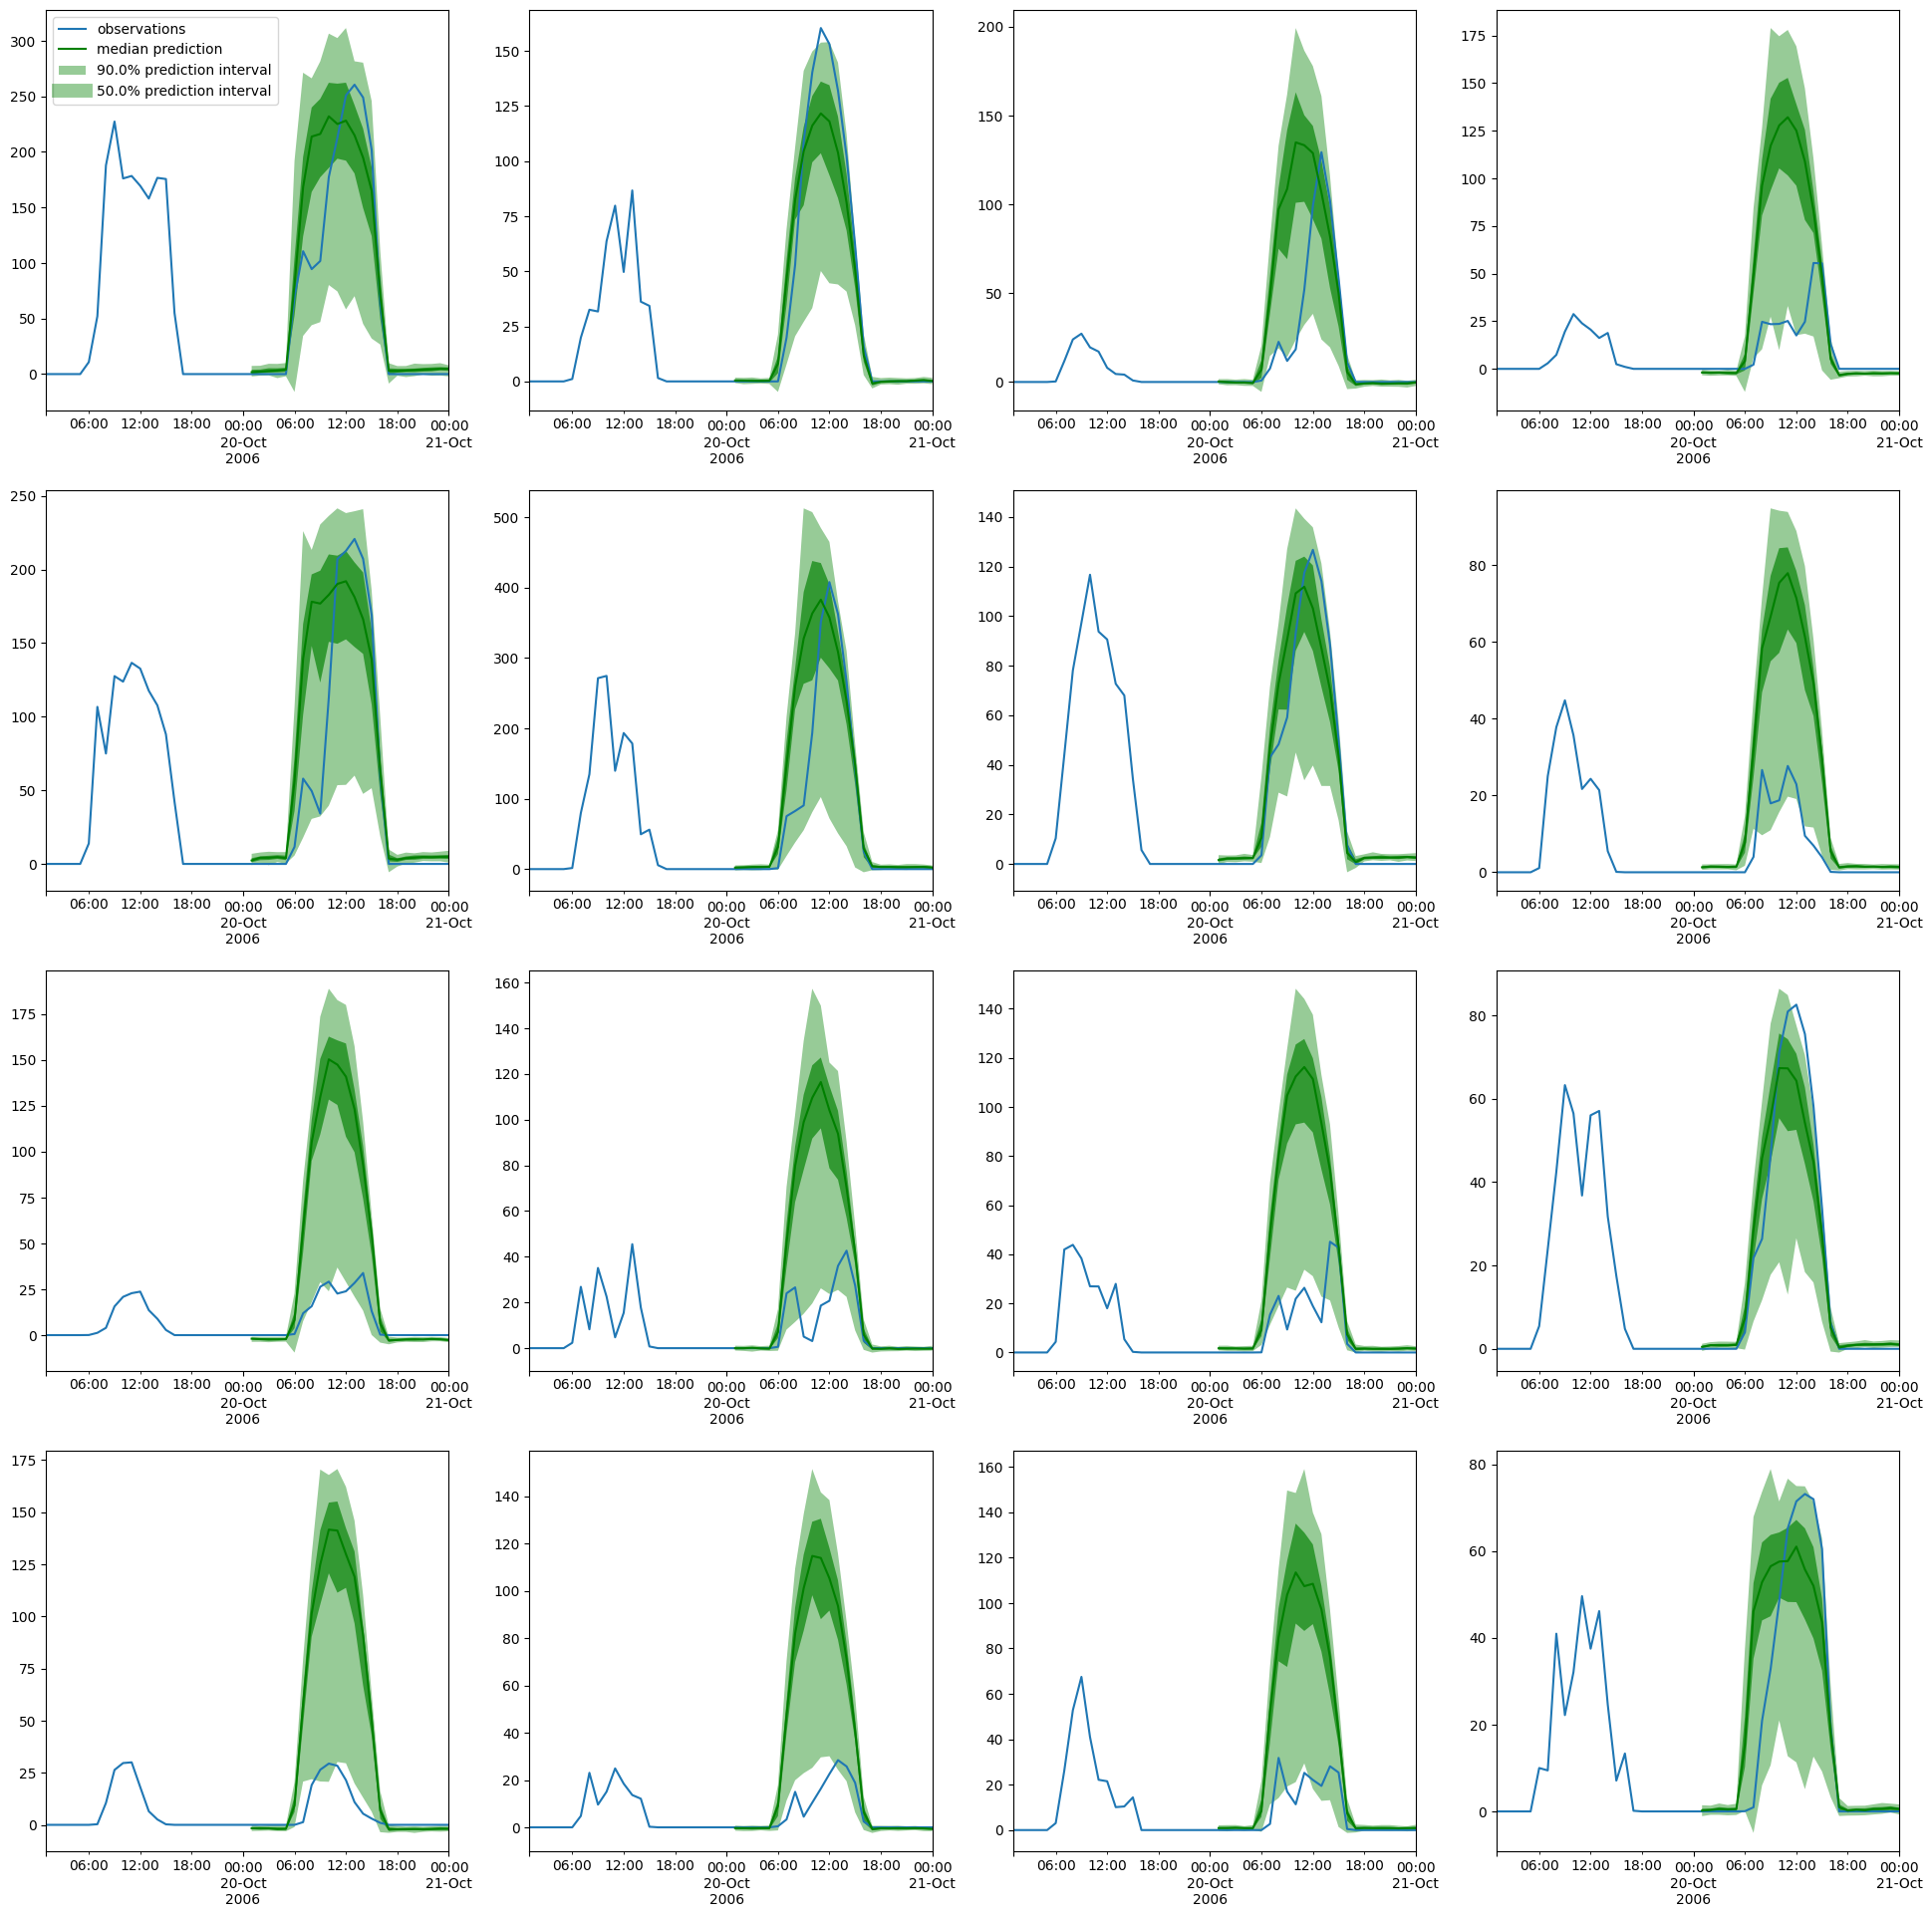

In [27]:
plot(
    target=targets[0],
    forecast=forecasts[0],
    prediction_length=dataset.metadata.prediction_length,
)
plt.show()